In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization
from optimization_class import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 150
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [34]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5

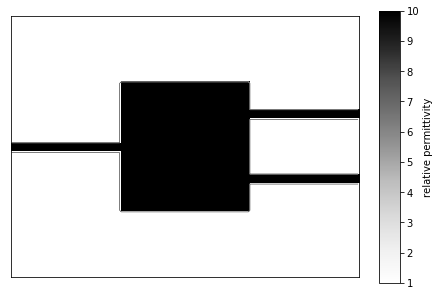

In [45]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, shape, eps_start=10)
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [46]:
eps = simulation.eps_r
pts_in = np.sum(eps[30,:] > 1)
pts_top = np.sum(eps[Nx-30,:ny] > 1)
pts_bot = np.sum(eps[Nx-30,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))


waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [90]:
# set the modal source and probes

# simulation to solve
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=25)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 0.8244140645417127 W/L0


In [91]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()

50 grids per wavelength


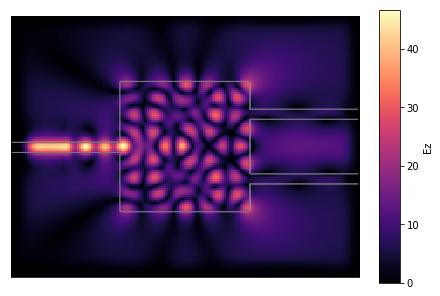

In [92]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [93]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

## Both Linear and Nonlinear

In [94]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*J_top)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*J_bot)))
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

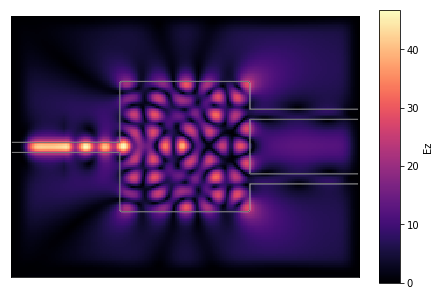

46.55764936431343 46.64727041517432


In [95]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
print(np.max(np.abs(Ez)), np.max(np.abs(Ez_nl)))

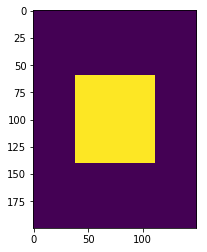

In [83]:
plt.imshow(design_region)

In [96]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=1000, J=J, dJdE=dJdE, eps_max=10, step_size=.05, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

 45% (456 of 1000) |#########            | Elapsed Time: 0:21:33 ETA:   0:38:27

the simulation did not converge, reached 0.20756802699389637


 48% (482 of 1000) |##########           | Elapsed Time: 0:23:22 ETA:   0:34:59

the simulation did not converge, reached 0.40772883984661384


 48% (486 of 1000) |##########           | Elapsed Time: 0:23:48 ETA:   0:28:03

the simulation did not converge, reached 0.14569861962758127


 48% (487 of 1000) |##########           | Elapsed Time: 0:24:02 ETA:   1:55:57

KeyboardInterrupt: 

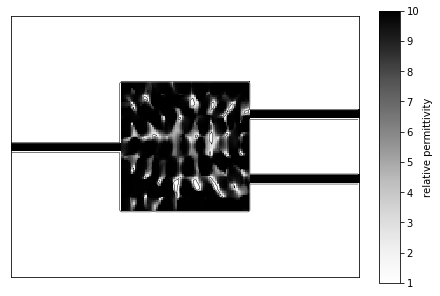

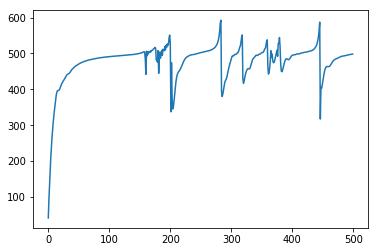

In [81]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

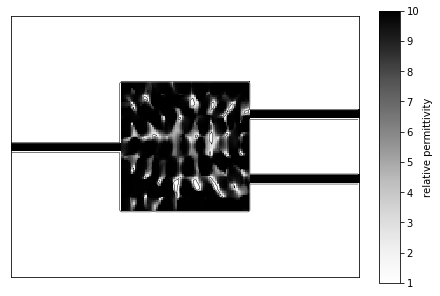

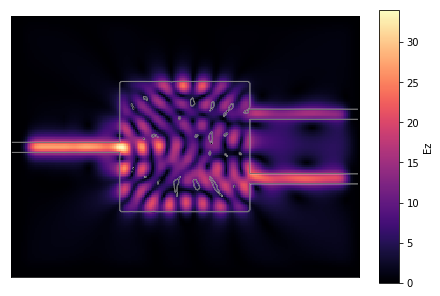

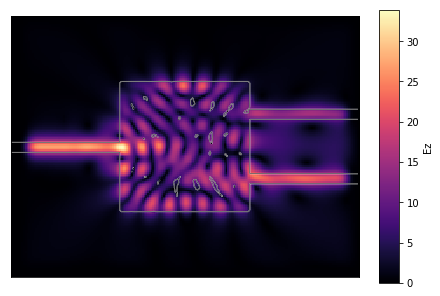

In [82]:
# eps_saved = np.load('../data/eps_good.npy')

# eps_saved[design_region == 0] = eps_r[design_region==0]
# simulation.reset_eps(eps_saved)

simulation.reset_eps(new_eps)
simulation.plt_eps()
W_in = simulation.W_in

(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()
W_top_lin = simulation.flux_probe('x', [Nx-35, ny+int(d/2/dl)], int(d/dl))
W_bot_lin = simulation.flux_probe('x', [Nx-35, ny-int(d/2/dl)], int(d/dl))
W_in_lin = simulation.flux_probe('x', [35, ny], 100)

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
W_top_nl = simulation.flux_probe('x', [Nx-35, ny+int(d/2/dl)], int(d/dl))
W_bot_nl = simulation.flux_probe('x', [Nx-35, ny-int(d/2/dl)], int(d/dl))
W_in_nl = simulation.flux_probe('x', [35, ny], 100)

simulation.plt_abs()
plt.show()

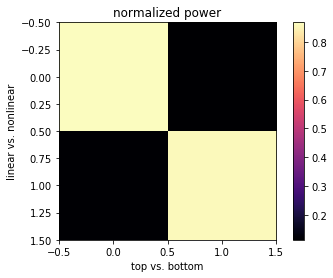

[[0.8678828  0.11287973]
 [0.11871649 0.86055357]]


In [65]:
S = np.array([[W_top_lin, W_bot_lin]/W_in_lin,[W_top_nl, W_bot_nl]/W_in_nl])
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.xlabel('top vs. bottom')
plt.ylabel('linear vs. nonlinear')
plt.title('normalized power')
plt.show()
print(S)

In [18]:
print(W_in, W_in_lin, W_in_nl)

6.463409377580575 -10.133761346629624 -9.88587541337557


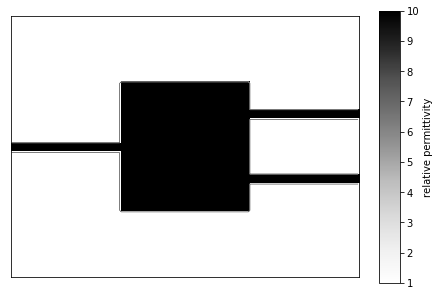

In [2]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 150
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 10
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, shape, eps_start=10)
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [3]:
eps = simulation.eps_r
pts_in = np.sum(eps[15,:] > 1)
pts_top = np.sum(eps[Nx-15,:ny] > 1)
pts_bot = np.sum(eps[Nx-15,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))

waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [13]:
# set the modal source and probes

# simulation to solve
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [15, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-15, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 6.463407204745043 W/L0


In [14]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()

50 grids per wavelength


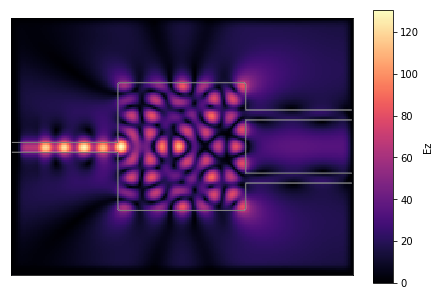

In [15]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True)

In [16]:
# Define some parameters for the optimization
eps_max = 10
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

In [17]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*J_top)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*J_bot)))
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

130.36760105160747 132.23535567209436


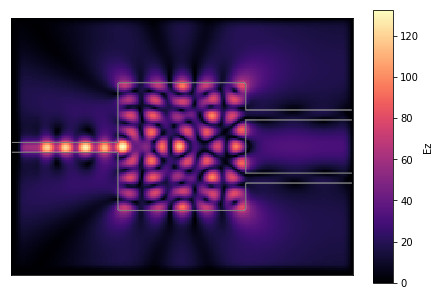

In [18]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show
print(np.max(np.abs(Ez)), np.max(np.abs(Ez_nl)))

In [22]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=2000, J=J, dJdE=dJdE, eps_max=10, step_size=.02, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

 41% (823 of 2000) |########             | Elapsed Time: 0:47:46 ETA:   1:05:17

the simulation did not converge, reached 0.47855306422413535


 41% (824 of 2000) |########             | Elapsed Time: 0:47:59 ETA:   4:05:58

the simulation did not converge, reached 0.49997933620169116


 41% (826 of 2000) |########             | Elapsed Time: 0:48:15 ETA:   1:10:02

the simulation did not converge, reached 0.3521616772207598


 41% (827 of 2000) |########             | Elapsed Time: 0:48:28 ETA:   4:06:20

the simulation did not converge, reached 0.5889997273275709


 41% (829 of 2000) |########             | Elapsed Time: 0:48:46 ETA:   1:44:17

the simulation did not converge, reached 0.22678394504168609


 41% (831 of 2000) |########             | Elapsed Time: 0:49:01 ETA:   0:50:00

RuntimeError: Pardiso - Number of perturbed pivot elements = 1. This could mean that the matrix is singular.

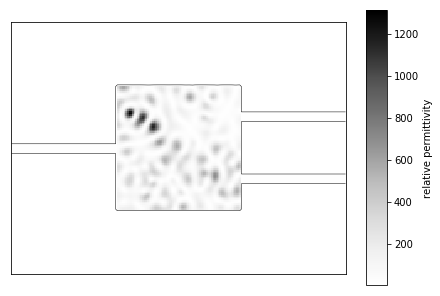

In [20]:
simulation.plt_eps()

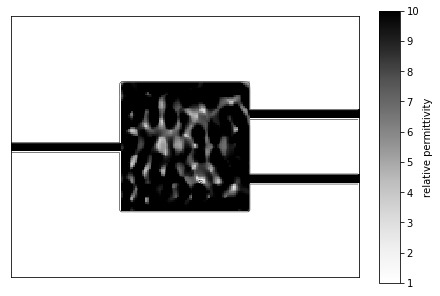

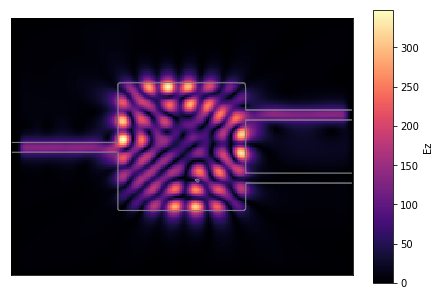

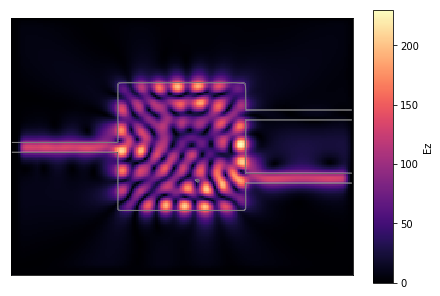

In [11]:
simulation.reset_eps(new_eps)
simulation.plt_eps()
W_in = simulation.W_in

(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()
W_top_lin = simulation.flux_probe('x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
W_bot_lin = simulation.flux_probe('x', [Nx-15, ny-int(d/2/dl)], int(d/dl))
W_in_lin = simulation.flux_probe('x', [20, ny], 100)

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
W_top_nl = simulation.flux_probe('x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
W_bot_nl = simulation.flux_probe('x', [Nx-15, ny-int(d/2/dl)], int(d/dl))
W_in_nl = simulation.flux_probe('x', [20, ny], 100)

simulation.plt_abs()
plt.show()